
### Scraping data from Skytrax

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [ ]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Flying A380 business class ...
1,✅ Trip Verified | British Airways absolutely ...
2,✅ Trip Verified | My recent experience with B...
3,✅ Trip Verified | This is to express our disp...
4,✅ Trip Verified | I flew London to Malaga on ...


In [ ]:
df.to_csv("BA_reviews.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [ ]:
df['reviews'] = df['reviews'].astype(str)

# Data Cleaning

In [ ]:
ba_df = df.copy()

In [ ]:
# Load the regular expression library
import re
# Remove punctuation
ba_df['reviews'] = ba_df['reviews'].map(lambda x: re.sub('[,\.!?|]', '', x))

# Convert the reviews to lowercase
ba_df['reviews'] = ba_df['reviews'].map(lambda x: x.lower())

# Function to remove short words
def remove_short_words(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) >= 3]
    return ' '.join(filtered_words)

# Apply the function to the 'reviews' column
ba_df['reviews'] = ba_df['reviews'].apply(remove_short_words)

ba_df['reviews'] = ba_df['reviews'].str.replace("✅ Trip Verified | ", " ");

# Print out the first rows of reviews
ba_df.head()

<ipython-input-39-402c7977d922>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  ba_df['reviews'] = ba_df['reviews'].str.replace("✅ Trip Verified | ", " ");


,reviews
0,trip verified flying a380 business class shoul...
1,trip verified british airways absolutely does ...
2,trip verified recent experience with british a...
3,trip verified this express our displeasure and...
4,trip verified flew london malaga august club e...


# EDA - Exploratory Data Analysis

## WordCloud

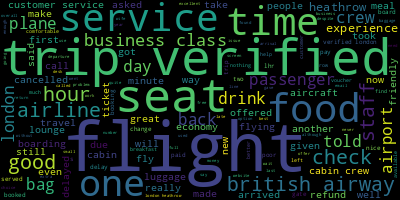

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(ba_df['reviews'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Topic Modelling

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc= The deaccent() function is another utility function, documented at the link, which does exactly what the name and documentation suggest: removes accent marks from letters, so that, for example, 'é' becomes just 'e'.)
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

reviews_list = ba_df.reviews.values.tolist()
reviews_token_list = list(sent_to_words(reviews_list)) # tokenize reviews data

# remove stop words
reviews_token_list = remove_stopwords(reviews_token_list)

# print first 30 words from the first review( document)
print(reviews_token_list[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['trip', 'verified', 'flying', 'business', 'class', 'pleasure', 'made', 'disaster', 'worst', 'seating', 'configuration', 'imaginable', 'could', 'sane', 'person', 'could', 'jam', 'many', 'seats', 'limited', 'space', 'expect', 'passengers', 'happy', 'seats', 'narrower', 'economy', 'airlines', 'must', 'face']


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(reviews_token_list)

# Create Corpus
texts = reviews_token_list

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [ ]:
from pprint import pprint

num_topics=10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"flight" + 0.009*"verified" + 0.008*"trip" + 0.007*"london" + '
  '0.006*"service" + 0.006*"crew" + 0.006*"seat" + 0.006*"check" + '
  '0.006*"british" + 0.005*"good"'),
 (1,
  '0.018*"flight" + 0.012*"verified" + 0.011*"service" + 0.010*"trip" + '
  '0.009*"get" + 0.008*"london" + 0.007*"cabin" + 0.006*"class" + '
  '0.006*"business" + 0.006*"staff"'),
 (2,
  '0.017*"flight" + 0.013*"verified" + 0.012*"trip" + 0.007*"service" + '
  '0.007*"one" + 0.007*"london" + 0.007*"check" + 0.006*"good" + 0.006*"bag" + '
  '0.005*"told"'),
 (3,
  '0.017*"flight" + 0.010*"verified" + 0.010*"trip" + 0.009*"one" + '
  '0.007*"seats" + 0.006*"hours" + 0.006*"service" + 0.005*"airways" + '
  '0.005*"check" + 0.005*"luggage"'),
 (4,
  '0.016*"flight" + 0.014*"verified" + 0.012*"trip" + 0.012*"service" + '
  '0.010*"food" + 0.010*"seats" + 0.008*"crew" + 0.008*"good" + 0.008*"seat" + '
  '0.007*"cabin"'),
 (5,
  '0.015*"flight" + 0.010*"verified" + 0.010*"trip" + 0.008*"time" + '
  '0.008*

In [ ]:
doc_lda

In [ ]:
!pip install pyLDAvis==2.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97718 sha256=ef6172328f1d72cae0ef79f46d1315440b1f54c1938962c004a9cb6624bbe1f8
  Stored in directory: /root/.cache/pip/wheels/d9/93/d6/16c95da19c32f037fd75135ea152d0df37254c25cd1a8b4b6c
Successfully built pyLDAvis


In [ ]:
import pyLDAvis.gensim


import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

# Display the visualization
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


In [ ]:
pyLDAvis.save_html(lda_display, 'lda_visualization.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Sentimental Analysis

In [ ]:
from textblob import TextBlob

# function to get sentiment polarity
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis
ba_df['Sentiment'] = ba_df['reviews'].apply(get_sentiment)

# Print the results
ba_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,reviews,Sentiment
0,trip verified flying a380 business class shoul...,Negative
1,trip verified british airways absolutely does ...,Negative
2,trip verified recent experience with british a...,Positive
3,trip verified this express our displeasure and...,Positive
4,trip verified flew london malaga august club e...,Negative


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


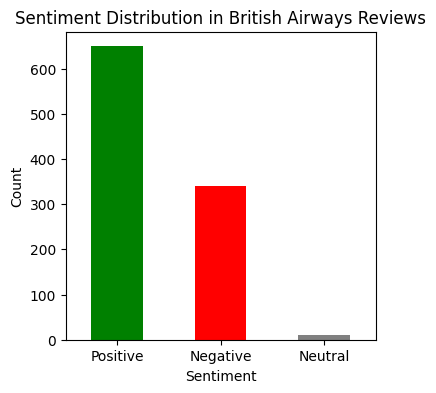

In [ ]:
import matplotlib.pyplot as plt

# count of each sentiment
sentiment_counts = ba_df['Sentiment'].value_counts()

# Create a bar chart
plt.figure(figsize=(4, 4))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Sentiment Distribution in British Airways Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


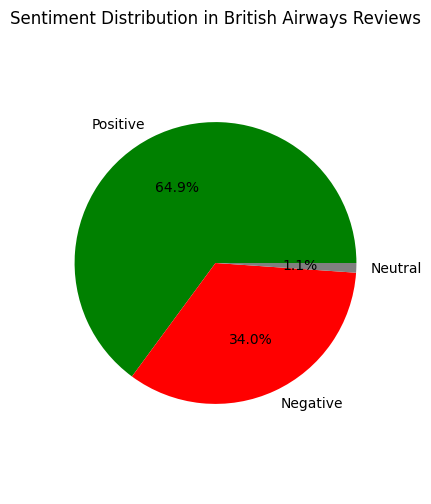

In [ ]:
# Create a pie chart
plt.figure(figsize=(4, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'red', 'gray'])
plt.title('Sentiment Distribution in British Airways Reviews')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [ ]:
ba_df

,reviews
0,flying a380 business class should be a plea...
1,british airways absolutely does not care my...
2,my recent experience with british airways w...
3,this is to express our displeasure and conc...
4,i flew london to malaga on 27 august in clu...
...,...
995,heathrow to athens on a321 arrived at the a...
996,london to bangkok i am not a fan if the ba c...
997,abu dhabi to london although a ba flight th...
998,gatwick to orlando stains on the seat cotto...
